In [1]:
# ESSENTIALS
import numpy as np
import matplotlib.pyplot as plt
import glob, os
from datetime import datetime

# CLUSTERING AND RANDOM FOREST
import skfuzzy as fuzz
from sklearn import tree
from sklearn import model_selection
from sklearn.datasets import make_blobs
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.svm import *
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay

# DATA LIBRARIES
# import rasterio
# import contextily as cx
import geopandas as gpd
import pandas as pd
import json
import pickle
import xarray
from xarray.core.dataarray import DataArray


# PREFERENCES
pd.set_option('display.max_columns', 500)
# plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

Define our Scikit-Learn Compliant Class so we can implement validation schemes within. Only two methods required: predict() and fit()

In [2]:
class ModelSelector():

    def __init__(self, c_kwargs={}, rf_kwargs={}):
       self.c_kwargs=c_kwargs        # CLUSTERING HYPERPARAMETERS
       self.rf_kwargs=rf_kwargs      # RANDOM FOREST HYPERPARAMETERS
       self.m = 2                    # EXPONENTIATION COEFFICIENT FOR CLUSTERING. TODO: MAKE ADJUSTABLE

    def fuzzyCluster(self, data):
        # Wraps Fuzzy Cluster function, only outputting percent belongs and formal cluster.

        # CHECK THAT REQUIRED FIELDS ARE IN KWARGS, IF NOT ADD
        if "error" not in self.c_kwargs:
            self.c_kwargs['error']=0.005

        if "maxiter" not in self.c_kwargs:
            self.c_kwargs['maxiter']=1000

        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, self.n_centers, self.m, **self.c_kwargs)
        label = np.argmax(u, axis=0)
        return cntr, u, fpc, label

    def howManyClusters(self, X, mintest=2,maxtest=15):
        # Determines how many clusters should be used using the Fuzzy Partitions Coefficient (FPC)
        # https://scikit-fuzzy.github.io/scikit-fuzzy/auto_examples/plot_cmeans.html#example-plot-cmeans-py
        # TODO: FIGURE OUT IF THIS METHOD IS APPROPRIATE OR NOT
        return 3
        fpcs = []
        listtests = np.arange(mintest,maxtest)
        for ncenters in listtests:
            self.n_centers = ncenters
            _, _, fpc, _ = self.fuzzyCluster(X)
            fpcs.append(fpc)
        return listtests[np.argmax(fpcs)]

    def train_rf(self, X_train, y_train, rf_controls={}):
        # ADAPTED FROM https://stackoverflow.com/questions/28489667/combining-random-forest-models-in-scikit-learn

        # RF CONTROLS PASSED DIRECTLY FROM PARAMETER, DEFAULT IS EMPTY
        rf = RandomForestRegressor(**rf_controls) 

        # RF FITTING 
        rf.fit(X_train, y_train)

        return rf

    def fit(self, attributes, model_perf):

        # CREATE RANDOM FOREST AND TRAIN
        self.rf = self.train_rf(attributes, model_perf, rf_controls=self.rf_kwargs)
        # print(r2_score(self.rf.predict(attributes), model_perf))

        return self

    def predict(self, attributes):

        # CHECK WHETHER MODEL HAS BEEN TRAINED
        if self.rf is None:
            raise(Exception("ModelSelector isn't trained!"))

        # GET RANDOM FOREST PREDICTION
        pred = self.rf.predict(attributes)


        return pred


Define function to get values from Random Forest

In [3]:
def runFitMetric_getMSE(fitmet, rf_kwargs={}):
    # FILEPATH TO SHAPEFILE CONTAINING CAMELS DATASET
    # camelsdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\HCDN_nhru_final\HCDN_nhru_final_671.shp"
    camelsdir = r"/home/ottersloth/ensemblennse/data/data/HCDN_nhru_final/HCDN_nhru_final_671.shp"
    
    # DIRECTORY TO FOLDER CONTAINING CAMELS ATTRIBUTE TEXTFILES
    # PRIOR TO THIS STEP MAKE SURE THE README IN THE FILE SYSTEM HAS BEEN REMOVED (or the file extension has been changed)
    attdir = r"/home/ottersloth/ensemblennse/data/data/camels_attributes_v2.0/camels_attributes_v2.0/"

    # READ CAMELS DATASET
    camels = gpd.read_file(camelsdir)

    # COPY TO KEEP ORIGINAL IN MEMORY
    camels_df = camels 

    # LOOP THROUGH AND JOIN
    filelist = glob.glob(attdir + "*.txt")
    for i in filelist:
        currdf = pd.read_csv(i, sep=";")
        camels_df = camels_df.merge(currdf, how='left', left_on="hru_id", right_on="gauge_id")

    # DEFINE WHAT WE WANT TO RUN ON
    # perf_dir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\hourly_performances\\"
    perf_dir = r"/home/ottersloth/ensemblennse/data/data/hourly_performances/"
    
    perf_metrics = [fitmet]

    # READ ALL CSV FILES IN DIRECTORY
    os.chdir(perf_dir)
    modelfiles = glob.glob("*.csv")

    # GET FIRST CSV FILE TO DEFINE DATAFRAME AND ADD PREFIX TO COLUMNS BASED ON NAME
    print(perf_dir + modelfiles[0])
    perf = pd.read_csv(perf_dir + modelfiles[0]).add_prefix(modelfiles[0][:-4] + "_")
    # GET COLUMN NAME CONTAINING "BASIN"
    fcol = [col for col in perf.columns if 'basin' in col]

    # LOOP FOR EACH CSV FILE
    for ii in range(1, len(modelfiles)):
        print(perf_dir + modelfiles[ii])
        # GET NEXT CSV FILE TO DEFINE DATAFRAME AND ADD PREFIX TO COLUMNS BASED ON NAME
        currdf = pd.read_csv(perf_dir + modelfiles[ii]).add_prefix(modelfiles[ii][:-4] + "_")

        # GET COLUMN NAME CONTAINING "BASIN"
        basin_col= [col for col in currdf.columns if 'basin' in col]
        # JOIN ON MATCHING BASINS
        perf = perf.merge(currdf, how="inner", left_on=fcol, right_on=basin_col)

    # GET COLUMN NAME CONTAINING "FITMET"
    perf_met = [col for col in perf.columns if fitmet in col]

    # CLEAN UP NONSENSICAL DATA (EG, BASIN LABELS)
    # SO LETS GET A LIST OF VARIABLE NAMES WE WANT TO KEEP.

    # TO START WE WILL KEEP THE SAME VARIABLES AS Kratzert et al. 2019, AS SHOWN BY OUR
    # INTERNAL SPREADSHEET Attributes_CAMELS_vs_NHDPlus
    varstokeep = ['organic_frac',
    'elev_mean_x',
    'slope_mean',
    'area_gages2',
    'soil_depth_pelletier',
    'sand_frac',
    'silt_frac',
    'clay_frac',
    'geol_permeability',
    'p_mean',
    'pet_mean',
    'aridity',
    'frac_snow',
    'high_prec_freq',
    'high_prec_dur',
    'low_prec_freq',
    'low_prec_dur']

    camels_df = camels_df.merge(perf, how="inner", left_on="hru_id", right_on=fcol)
    inputdataset = camels_df[varstokeep]
    outputdataset = camels_df[perf_met]
    
    
    nsplits = 5
    kf = KFold(n_splits=nsplits, shuffle=True)


    testvalues = np.zeros((inputdataset.shape[0], outputdataset.shape[1]))                  # CONTAINER FOR PERFORMANCE VALUES WHEN BASIN IN TEST SET
    modelno = 0                                                              # COUNTER FOR MODEL CONTAINER
    test_modelno = np.zeros((inputdataset.shape[0], outputdataset.shape[1]))                # MODEL IN WHICH BASIN WAS IN TEST SET
    test_modellist = list()                                                  # MODEL CONTAINER
    featureimportance = list()
    msetest = list()
    msetrain = list()
    msemeta = list()

    currout=outputdataset

    # KFOLD SPLIT OF DATASETS
    for train, test in kf.split(inputdataset):            
        # CODE FOR INDIVIDUAL MODEL TRAINING
        for ii in range(currout.shape[1]):
            # TRAIN MODEL ON TRAINING SET
            model = None
            model = ModelSelector(rf_kwargs=rf_kwargs)
            model.fit(inputdataset.iloc[train, :], currout.iloc[train, ii])

            # PERFORM PREDICTION ON TRAIN SET AND GET FIT METRICS
            train_pred = model.predict(inputdataset.iloc[train, :])
            trainrms = mse(train_pred, currout.iloc[train, ii].to_numpy())
            trainr2 = r2_score(train_pred, currout.iloc[train, ii].to_numpy())

            # PERFORM PREDICTION ON TEST SET AND GET FIT METRICS
            model_pred = model.predict(inputdataset.iloc[test, :])
            testrms = mse(model_pred, currout.iloc[test, ii].to_numpy())
            testr2 = r2_score(model_pred, currout.iloc[test, ii].to_numpy())

            # SAVE VALUES IN CONTAINERS ABOVE
            testvalues[test, ii] = model_pred
            test_modelno[test, ii] = modelno
            modelno = modelno + 1
            test_modellist.append(model)
            msetest.append(testrms)
            msetrain.append(trainrms)

            # print(f"Test R2: {testr2:.3f} | Meta R2: {metar2:.3f} | Test MSE: {testrms:.3f} | Meta MSE: {metarms:.3f} | Model ID: {ii}")


    return camels_df, inputdataset, outputdataset, testvalues, test_modelno, test_modellist, featureimportance

In [4]:
rfargs =  {"n_estimators": 15}
camels_df, inputs, target, testvalues, test_modelno, test_modellist, featureimportance = runFitMetric_getMSE("nnse",rf_kwargs=rfargs)

/home/ottersloth/anaconda3/envs/ensemble/lib/python3.8/site-packages/geopandas/geodataframe.py:1483: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
/home/ottersloth/anaconda3/envs/ensemble/lib/python3.8/site-packages/geopandas/geodataframe.py:1483: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


/home/ottersloth/ensemblennse/data/data/hourly_performances/CFE.csv
/home/ottersloth/ensemblennse/data/data/hourly_performances/LSTM.csv


In [5]:
# THIS IS THE BEST PREDICTED MODEL
# CALCULATED AS THE MAXIMUM OF THE PREDICTED PERFORMANCES
# BEST PRED MODEL = BPM
bpm_idx = np.argmax(testvalues, axis=1)
bpm_perf = testvalues[np.arange(testvalues.shape[0]), bpm_idx]

# THIS IS THE BEST ACTUAL MODEL
# CALCULATED AS THE MAXIMUM OF THE ACTUAL PERFORMANCES
# BEST ACTUAL MODEL = BAM
target_perf = target.to_numpy()
bam_idx = np.argmax(target_perf, axis=1)
bam_perf = target_perf[np.arange(testvalues.shape[0]), bam_idx]

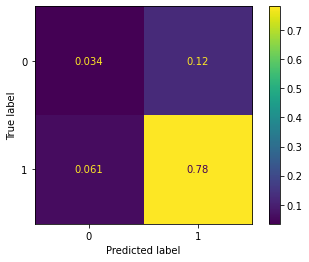

In [6]:
# PLOT CONFUSION MATRIX
ConfusionMatrixDisplay.from_predictions(bam_idx, bpm_idx, normalize='all')

(array([24., 14., 11.,  7.,  7.,  7.,  8.,  3.,  3.,  1.,  0.,  0.,  1.,
         0.,  3.,  0.,  0.,  1.,  0.,  1.]),
 array([3.51420000e-04, 2.69252126e-02, 5.34990053e-02, 8.00727979e-02,
        1.06646591e-01, 1.33220383e-01, 1.59794176e-01, 1.86367969e-01,
        2.12941761e-01, 2.39515554e-01, 2.66089346e-01, 2.92663139e-01,
        3.19236932e-01, 3.45810724e-01, 3.72384517e-01, 3.98958310e-01,
        4.25532102e-01, 4.52105895e-01, 4.78679688e-01, 5.05253480e-01,
        5.31827273e-01]),
 <BarContainer object of 20 artists>)

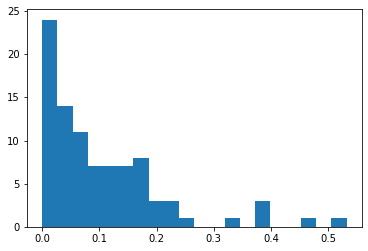

In [7]:
# IN SAMPLES THAT ARE NOT CORRECTLY CLASSIFIED (ie, bpm_idx != bam_idx)
# HOW FAR OFF ARE THE TWO ACTUAL PERFORMANCES?
wrong_model = np.where(bpm_idx != bam_idx, True, False)
wrong_model_perfdiff = np.abs(target_perf[wrong_model, 0] - target_perf[wrong_model, 1])
plt.hist(wrong_model_perfdiff, bins=20)

In [20]:
def softmax(x):
    # ADAPTED FROM https://www.delftstack.com/howto/numpy/numpy-softmax/
    maxx = np.max(x,axis=1,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x - maxx) #subtracts each row with its max value
    sumx = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / sumx 
    return f_x

def ensemblePerf(perf, target, threshold=0.2, n=1, softmax = False):
    # TODO: CONSIDER DOING A MORE ROBUST THING WERE YOU CALCULATE THE DIFFERENCE
    # BETWEEN EACH PERFORMANCE AND THE MINIMUM OF THE ROW WITHOUT ITSELF
    # THEN, RUN A NP.WHERE TO ESTABLISH THAT IF BIGGER THAN THRESHOLD, SET TO NAN
    # AND CALCULATE THE NORMALIZED PERFORMANCE FROM THERE, ONLY NECESSARY WITH MORE THAN
    # 2 MODELS

    # RANGE OF EACH ROW
    rn = np.max(perf, axis=1) - np.min(perf, axis=1)
    
    # THIS IS THE BEST PREDICTED MODEL
    # CALCULATED AS THE MAXIMUM OF THE PREDICTED PERFORMANCES
    # BEST PRED MODEL = BPM
    bpm_idx = np.argmax(perf, axis=1)
    bpm_perf = perf[np.arange(perf.shape[0]), bpm_idx]

    # CALCULATE THE VALUES FOR ENSEMBLING MODELS
    
    # EXPONENTIAL SETUP
    if not softmax:
        perf_w = perf ** n
        row_sums = perf_w.sum(axis=1)
        perf_norm = perf_w / row_sums[:, np.newaxis]
    else: 
        perf_norm = softmax(perf)
    
    ens_perf = np.sum(target * perf_norm, axis=1)

    # THIS IS THE BEST ACTUAL MODEL
    # CALCULATED AS THE MAXIMUM OF THE ACTUAL PERFORMANCES
    # BEST ACTUAL MODEL = BAM
    target_perf = target.to_numpy()
    bam_idx = np.argmax(target_perf, axis=1)
    bam_perf = target_perf[np.arange(testvalues.shape[0]), bam_idx]
    
    # CREATE OUTPUT STRUCTURE
    output = np.where(rn < threshold, ens_perf, bam_perf)
    exceed = np.where(rn > threshold, True, False)
    print(exceed.shape)
    perf_norm[exceed, :] = 0
    perf_norm[np.where(exceed), bpm_idx[exceed]] = 1

    return output, perf_norm

(495,)


Text(0, 0.5, 'NNSE')

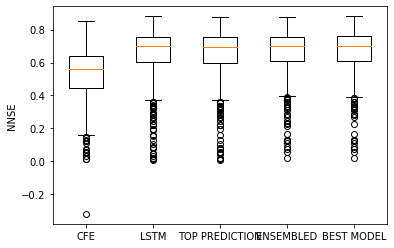

In [10]:
# ACTUAL MODEL PERFORMANCE = AMP
amp = target.to_numpy()
cfe = amp[:, 0]
lstm = amp[:, 1]
bestpred = amp[np.arange(amp.shape[0]), bpm_idx]
ensemble, weights = ensemblePerf(testvalues, target, threshold=0.02)
bestmodel = bam_perf

plt.boxplot([cfe, lstm, bestpred, ensemble, bestmodel], labels=["CFE", "LSTM", "TOP PREDICTION", "ENSEMBLED", "BEST MODEL"])
plt.ylabel("NNSE")

In [11]:
camels_df['weight_CFE'] = weights[:, 0]
camels_df['weight_LSTM'] = weights[:, 1]

weights_df = camels_df[['hru_id', 'weight_CFE', 'weight_LSTM']]
weights_df.head()

,hru_id,weight_CFE,weight_LSTM
0,1022500,0.0,1.0
1,1031500,0.0,1.0
2,1047000,0.0,1.0
3,1052500,0.0,1.0
4,1054200,0.0,1.0


In [12]:
def summarize(a, perc=[0, 25, 50, 75, 100]):
    p = np.nanpercentile(a, perc)
    p = np.append(p, np.nanmean(a))
    return p

outp = [cfe, lstm, bestpred, ensemble, bestmodel]

for i in outp:
    print(summarize(i))

[-0.32075337  0.44478516  0.55759623  0.63957011  0.85139258  0.52642402]
[0.00974678 0.60135387 0.69821297 0.75681638 0.88147345 0.6533368 ]
[0.00974678 0.5972153  0.69499495 0.75502266 0.87542015 0.64916084]
[0.01784125 0.60956857 0.69862666 0.75625911 0.87542015 0.66339555]
[0.01784125 0.6114751  0.70338046 0.76036236 0.88147345 0.66823445]


In [13]:
# ADAPTED FROM https://github.com/neuralhydrology/neuralhydrology/blob/1ff36ea8c8eff99ad25fa0f56f0119acbc9e6799/neuralhydrology/evaluation/metrics.py
def nse(obs: DataArray, sim: DataArray) -> float:
    denominator = ((obs - obs.mean())**2).sum()
    numerator = ((sim - obs)**2).sum()
    value = 1 - numerator / denominator
    return float(value)

In [12]:
# import matplotlib.image as mpimg
# img = mpimg.imread('/home/ottersloth/cfe_calibration/results/images/Validation/1632000_validation_300.png')
# imgplot = plt.imshow(img)
# plt.show()

In [13]:
# PWD: /home/ottersloth/neuralhydrology/nextgen-form-eval/run_hourly/runs/full_runs/runs
# with open('/home/ottersloth/cfe_calibration/results/val_runs/1632000_val_run_300.json') as json_file:
#    data = json.load(json_file)

# test = data["validation sims"]

In [14]:
lstm_dir = '/home/ottersloth/neuralhydrology/nextgen-form-eval/run_hourly/runs/full_runs/runs/'
file_list = os.listdir(lstm_dir)
file_list.remove('failed_runs')
file_list.remove('hydro_signatures')

num_files = len(file_list)

lstm_results = {}
lstm_results['basin_id'] = []
lstm_results['sim'] = []

for i in range(num_files): 
    lstm_test_dir = os.path.join(lstm_dir,file_list[i])
    lstm_test_file = os.path.join(lstm_test_dir,"test", "model_epoch003","test_results.p")
    with open(lstm_test_file, "rb") as fp:
        results = pickle.load(fp)
    
    basin_id = [i for i in results.keys()]

    for j in range(len(basin_id)):
        sim = results[basin_id[j]]['1H']['xr']['QObs_CAMELS(mm/h)_sim'].values
        sim = [float(sim[i]) for i in range(len(sim))]
        
        lstm_results['sim'].append(sim)
        lstm_results['basin_id'].append(basin_id[j])

df_lstm_results = pd.DataFrame(lstm_results)

In [15]:
df_lstm_results.head()

,basin_id,sim
0,01054200,"[0.02949778363108635, 0.02937062457203865, 0.0..."
1,01423000,"[0.03434738144278526, 0.034167151898145676, 0...."
2,01439500,"[0.02608576789498329, 0.02575831487774849, 0.0..."
3,01542810,"[0.018778089433908463, 0.018176991492509842, 0..."
4,01583500,"[0.03036067634820938, 0.029848922044038773, 0...."


In [18]:
# DEFINE DIR WITH ALL STREAMFLOW DATA 
q_dir = "/home/ottersloth/data/camels_hourly/usgs_streamflow"

# TEST PERIOD
test_start=datetime.strptime("2002-09-30 23:00:00", '%Y-%m-%d %H:%M:%S')
# ORIGINALLY UNTIL 11 PM, CHANGED BECAUSE COMPARISON FUNCTION IS INCLUSIVE LATER ON
test_end=datetime.strptime("2007-09-30 22:00:00", '%Y-%m-%d %H:%M:%S') 

# GET ALL CFE VALIDATION FILES 
cfe_dir = "/home/ottersloth/cfe_calibration/results/val_runs/"
os.chdir(cfe_dir)
filelist = glob.glob("*.json")

basinlist = list()
outnnselist = list()


for i in range(len(filelist)): 
    
    # GET FILE NAME FROM CONTAINER
    file = filelist[i]
    
    # GET BASIN ID BY SPLITTING FILENAME
    basinid_raw = file.split("_")[0]
    basinid = '%08d' % int(basinid_raw) # ZERO PADDING
    
    # GET TIMESERIES FROM LSTM DATAFRAME
    match = df_lstm_results[df_lstm_results["basin_id"] == basinid]
    
    # SINCE NOT THE SAME BASINS WERE RUN, CHECK WE ACTUALLY GOT A MATCH
    if match.shape[0] != 1:
        print(f"Skipping {basinid}")
        continue
    
    # CONVERT TIMESERIES TO NP ARRAY
    ts_lstm = np.array(match.iloc[0, 1])
    
    # NOW READ CFE FILE
    with open(file) as json_file:
        data = json.load(json_file)
    
    # CONVERT TIMESERIES TO NUMPY ARRAY
    ts_cfe = np.array(data['validation sims'])
    
    # GET MODEL WEIGHTS 
    weights = weights_df[weights_df["hru_id"] == int(basinid)].to_numpy()
    weights = weights[0][1:]

    # weights = weights[1:]
    
    # APPLY WEIGHTS
    ts_final = (weights[0] * ts_cfe + weights[1] * ts_lstm)
    
    # GET Q FROM USGS FOR TEST PERIOD
    q_read = pd.read_csv(f"{q_dir}/{basinid}-usgs-hourly.csv")
    q_read["datetime"] = pd.to_datetime(q_read['date'], format='%Y-%m-%d %H:%M:%S') # CONVERT TO DATETIME
    q_match = q_read[q_read.datetime.between(test_start, test_end)]
    ts_q = q_match['QObs_CAMELS(mm/h)'].to_numpy()
    
    # CALCULATE NSE 
    nse_calc = nse(ts_q, ts_final)
    
    # CALCULATE NNSE
    nnse = 1 / (2 - nse_calc)
    
    print(f"{basinid} {nnse}")
    
    # SAVE IN PROPER FORMAT
    basinlist.append(basinid)
    outnnselist.append(nnse)
    


01547700 0.7177911100494252
05503800 0.6739697635506895
06906800 0.6053627288626233
03498500 0.731458813762594
01548500 0.8537188397326884
05507600 0.6709957383052539
06910800 0.790772974900458
03500000 0.8169021913185778
01549500 0.7518112405177181
06911900 0.7011129036923455
05508805 0.7328781357668558
03504000 0.7509120345242769
01550000 0.8180592794482568
06917000 0.8386153842521218
05525500 0.7750162715575347
03574500 0.6570862535906954
01557500 0.7828609918280253
06918460 0.6155269036109012
05556500 0.4029400565441064
03604000 0.7413590019876947
01568000 0.8294336663033889
06921070 0.6613783174517147
05584500 0.5336773320470016
04015330 0.6113809033593346
01580000 0.6541598417796786
06921200 0.6552035953708776
01583500 0.6600382988083188
04024430 0.5985144676478336
05591550 0.6520771267669991
07057500 0.7563382813805494
01586610 0.7115525899023728
04027000 0.6434911603753013
05592050 0.7970605217037313
07060710 0.6887787847572758
01591400 0.6516941798361944
05592575 0.69008147837

14137000 0.4138201651203278
01350000 0.8068583533470419
09107000 0.2893443381360991
11523200 0.688287381342917
14138800 0.77407857587909
01350080 0.7635518250204126
14138870 0.5400586669134861
09210500 0.6336697327842628
11528700 0.7574474968965337
01350140 0.7341953231486225
09223000 0.722762372812233
14138900 0.7170600386783215
11532500 0.8718231555017796
01365000 0.76132171047954
09306242 0.009511317458204292
14139800 0.8075240242710481
12010000 0.8530260966462065
01411300 0.6114851312072191
09312600 0.6470661916779095
14141500 0.6239122622237019
12013500 0.7490002045887684
01413500 0.7871721087729657
09352900 0.6502561852729855
14154500 0.7722867129136728
12020000 0.8296906998415247
01414500 0.7163566033301877
14158790 0.8326429715747194
09378170 0.5118998045404062
12025700 0.6813343506543029
01415000 0.7395003357424471
14166500 0.7348172425550289
09386900 0.18925846817597247
01423000 0.7903405363650109
12035000 0.8753297514728882
09404450 0.49753910264939144
14182500 0.83056217243

/tmp/ipykernel_194414/625429212.py:55: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  q_read = pd.read_csv(f"{q_dir}/{basinid}-usgs-hourly.csv")


14236200 0.8252755768579992
09497980 0.7652151151025098
01484100 0.4699618020168061
12082500 0.765853625959942
09505350 0.7015001892840537
14301000 0.8347527157255165
01487000 0.6507905991452895
14303200 0.218867392798685
09505800 0.5708592763929929
12092000 0.5980892418494882
01491000 0.6688726370885784
14305500 0.8197389865719575
09508300 0.6955918555143346
12114500 0.6634741982898933
01516500 0.7405849410273493
14306340 0.8193714532458969
09510200 0.8079068716387996
12115000 0.73361939108349
01518862 0.7662289017462123
14306500 0.8436935505539435
09512280 0.4597529796330596
12117000 0.7868424080525162
01532000 0.8012989928211945
14308990 0.6416334799114812
09513780 0.6474287065511212
12143600 0.7686775449568664
01539000 0.8339847584535365
14309500 0.8318406613254955
12144000 0.8422831458857838
01542810 0.731652275333051
14316700 0.7520800464063789
12145500 0.8432551581891092
01543000 0.8356740086844826
14325000 0.7953745651192167
01543500 0.8626698186762332
12147500 0.79230546125170

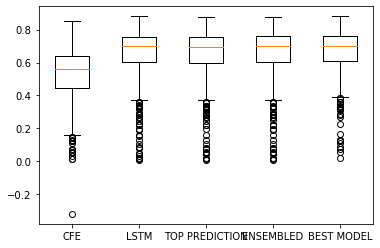

In [19]:
a = plt.boxplot([cfe, lstm, bestpred, np.array(outnnselist), bestmodel], labels=["CFE", "LSTM", "TOP PREDICTION", "ENSEMBLED", "BEST MODEL"])

In [72]:
#q_dir = "/home/ottersloth/data/camels_hourly/usgs_streamflow/02216180-usgs-hourly.csv"
#test = pd.read_csv(q_dir)

#test_start=datetime.strptime("2002-09-30 23:00:00", '%Y-%m-%d %H:%M:%S')
#test_end=datetime.strptime("2007-09-30 22:00:00", '%Y-%m-%d %H:%M:%S')

#test["datetime"] = pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S')

#test.head()

#outtest = test[test.datetime.between(test_start, test_end)]

#ts_test = outtest['QObs_CAMELS(mm/h)'].to_numpy()